In [1]:
import confirm.outlaw.nb_util as nb_util

nb_util.setup_nb()

import pickle
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax

# Run on CPU because a concurrent process is probably running on GPU.
jax.config.update("jax_platform_name", "cpu")

import confirm.mini_imprint.lewis_drivers as lts
from confirm.lewislib import lewis

import adastate
from criterion import Criterion
from diagnostics import lamstar_histogram

In [2]:
name = "4d_full"
params = {
    "n_arms": 4,
    "n_stage_1": 50,
    "n_stage_2": 100,
    "n_stage_1_interims": 2,
    "n_stage_1_add_per_interim": 100,
    "n_stage_2_add_per_interim": 100,
    "stage_1_futility_threshold": 0.15,
    "stage_1_efficacy_threshold": 0.7,
    "stage_2_futility_threshold": 0.2,
    "stage_2_efficacy_threshold": 0.95,
    "inter_stage_futility_threshold": 0.6,
    "posterior_difference_threshold": 0,
    "rejection_threshold": 0.05,
    "key": jax.random.PRNGKey(0),
    "n_table_pts": 20,
    "n_pr_sims": 100,
    "n_sig2_sims": 20,
    "batch_size": int(2**12),
    "cache_tables": f"./{name}/lei_cache.pkl",
}
lei_obj = lewis.Lewis45(**params)

In [3]:
with open(f"./{name}/data_params.pkl", "rb") as f:
    P, D = pickle.load(f)
load_iter = "latest"
S, load_iter, fn = adastate.load(name, load_iter)

loading checkpoint 4d_full/3880.pkl


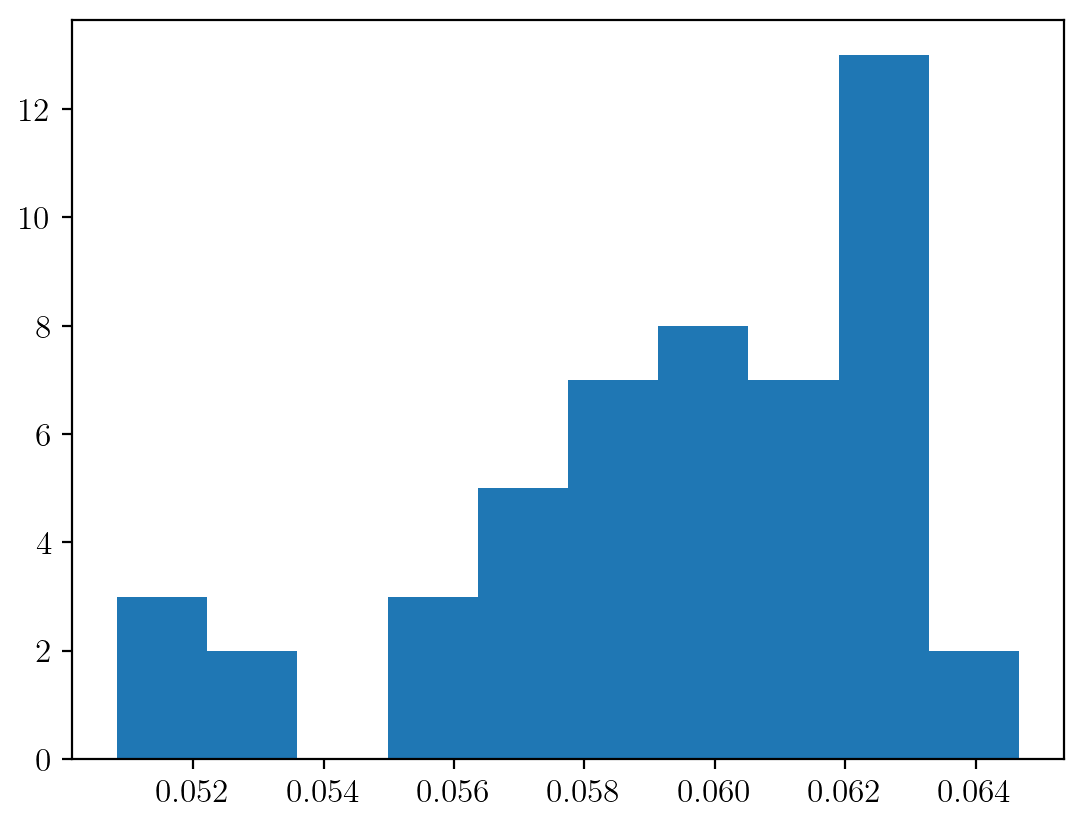

In [5]:
plt.hist(S.B_lam.min(axis=0))
plt.show()

In [6]:
cr = Criterion(lei_obj, P, S, D)
assert S.twb_max_lam[cr.twb_worst_tile] == np.min(S.twb_max_lam)
assert S.twb_min_lam[cr.twb_worst_tile] == np.min(S.twb_min_lam[cr.ties])

simulating with K=524288 and n_tiles=1 and batch_size=(1, 16384)
simulation runtime 6.833362340927124


In [17]:
Blamsort = S.B_lam.argsort(axis=0)

array([18120221, 19408047, 18117697, 18120221, 18117297, 19407647, 19404921, 19405483, 19405427,
       19408121, 18163277, 19407689, 19407385, 19408265, 18120177, 19408137, 19408127,   224833,
       19407883, 19405387,   224818, 19408189, 19404907, 19405369, 18119825, 19407833, 18145161,
       18118625, 12267375, 19407625, 19407833, 19407469, 14326436, 18120221, 19405451, 18119437,
       18117425, 19404785, 18116305, 19408157, 19404825, 14318483, 18163405, 19407915, 18145801,
         224827, 18122285, 19408027, 19408127, 19408139])

In [19]:
origlamsort = S.orig_lam.argsort()

In [22]:
Blamsort[0]

array([18119421, 19408121, 18116897, 18117021, 18122097, 19407609, 19404923, 19405387, 19405345,
       19408127, 18161825, 19407725, 19407499, 19408267, 18163041, 19408207, 19408265,   224827,
       19408027, 19405467,   224836, 19408045, 19404857, 19405387, 18119821, 19407915, 18145673,
       18120625, 12182810, 19407659, 19407947, 19407327, 14326446, 18117425, 19405387, 18116285,
       18116625, 19404803, 18120097, 19408287, 19404809, 14318472, 18161889, 19407803, 18145417,
         224839, 18116497, 19407993, 19408095, 19408287])

In [39]:
import confirm.mini_imprint.lewis_drivers as ld

for i in [0, 1, 10, 100, 200, 300, 500, 750, 1000, 5000, 10000, 100000]:
    B_lamss_idx = Blamsort[i, :]
    B_lamss = S.B_lam[B_lamss_idx, np.arange(S.B_lam.shape[1])]
    overall_tile = origlamsort[i]
    overall_lam = S.orig_lam[overall_tile]
    bootstrap_min_lams = np.concatenate(([overall_lam], B_lamss))
    overall_stats = ld.one_stat(
        lei_obj,
        S.g.theta_tiles[overall_tile],
        S.g.null_truth[overall_tile],
        S.sim_sizes[overall_tile],
        D.unifs,
        D.unifs_order,
    )
    overall_typeI_sum = (overall_stats[None, :] < B_lamss[:, None]).sum(axis=1)
    bias = (overall_typeI_sum[0] - overall_typeI_sum[1:].mean()) / S.sim_sizes[
        overall_tile
    ]
    print(f"index={i} bias={bias:5f}")

index=0 bias=0.001506
index=1 bias=0.001506
index=10 bias=0.001506
index=100 bias=0.001190
index=200 bias=0.001006
index=300 bias=0.000909
index=500 bias=0.000863
index=750 bias=0.000742
index=1000 bias=0.000417
index=5000 bias=0.000173
index=10000 bias=0.000230
index=100000 bias=0.000002


In [ ]:
overall_typeI_sum = (overall_stats[None, :] < bootstrap_min_lams[:, None]).sum(axis=1)
bias = (overall_typeI_sum[0] - overall_typeI_sum[1:].mean()) / S.sim_sizes[overall_tile]

In [10]:
cr.bias

0.0015673828125000004

In [12]:
tie = cr.overall_typeI_sum / S.sim_sizes[cr.overall_tile]
tie[0] - np.mean(tie[1:])

0.0015673828125000004

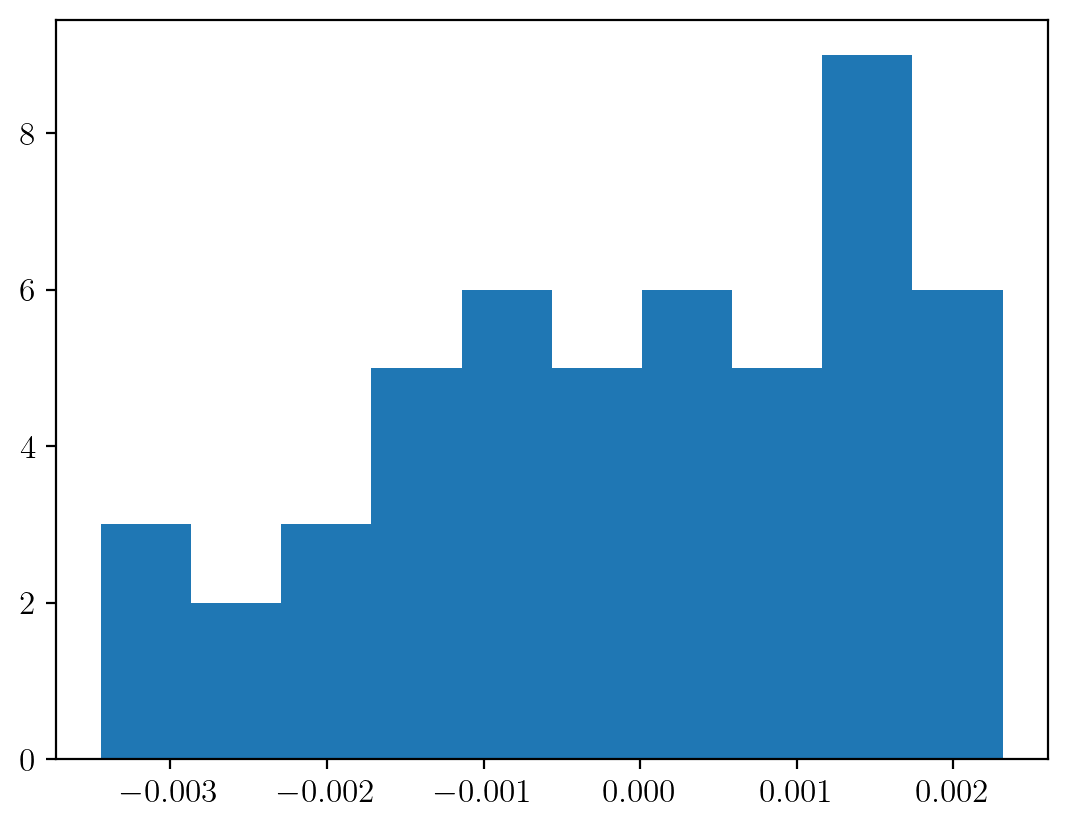

In [16]:
biases = [tie[i] - np.mean(np.delete(tie, i)) for i in range(1, len(tie))]
plt.hist(biases)
plt.show()

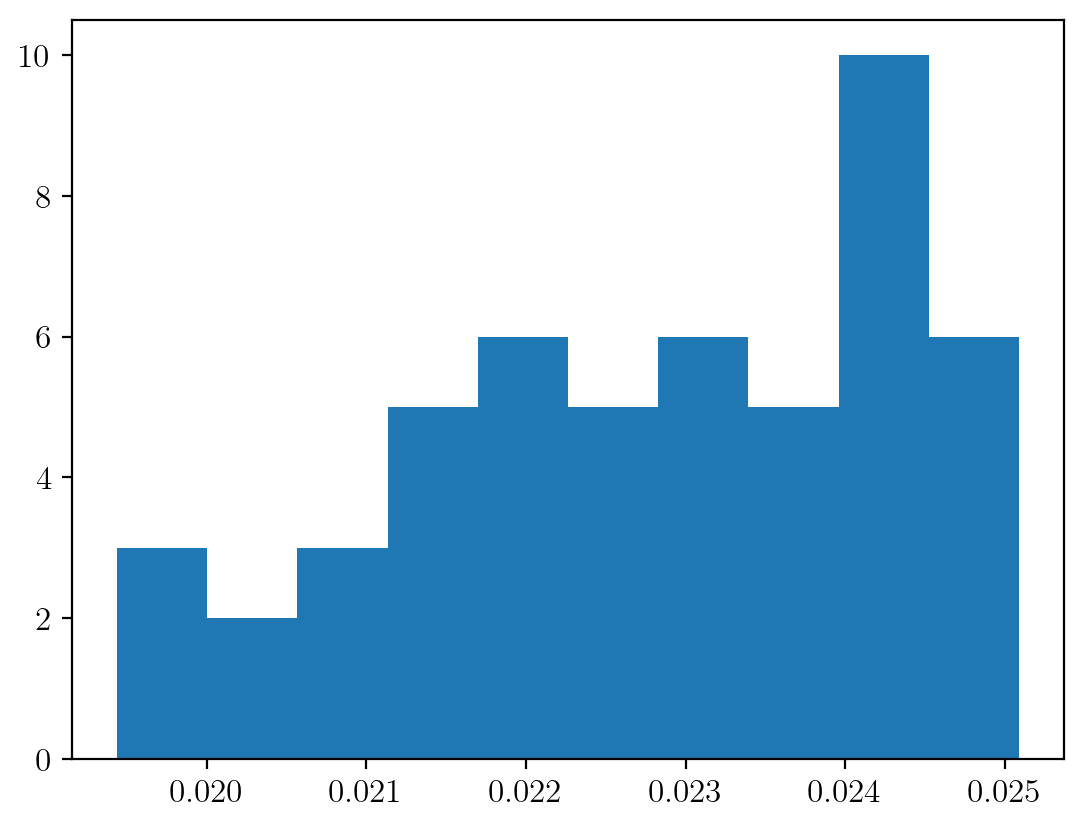

In [9]:
plt.hist()
plt.show()

In [5]:
idxs = cr.dangerous[:10]
alpha0_new = adastate.AdaRunner(P, lei_obj).batched_invert_bound(
    S.g.theta_tiles[idxs], S.g.vertices(idxs)
)
alpha0_new

array([0.02441603, 0.02441603, 0.02441605, 0.02441605, 0.02441603, 0.02441603, 0.02441605,
       0.02441605, 0.02441605, 0.02441603])

In [6]:
alpha0_new, alpha0_new - S.alpha0[idxs]

(array([0.02441603, 0.02441603, 0.02441605, 0.02441605, 0.02441603, 0.02441603, 0.02441605,
        0.02441605, 0.02441605, 0.02441603]),
 array([4.17179956e-06, 4.17179956e-06, 4.17847389e-06, 4.17847389e-06, 4.17179956e-06,
        4.17179956e-06, 4.17847389e-06, 4.17847389e-06, 4.17847389e-06, 4.17179956e-06]))

## 11/1/2022

In [7]:
import pandas as pd

In [8]:
# orderer = combined_mean_idx + inflation * (combined_min_idx - combined_mean_idx)
# orderer = S.twb_mean_lam + inflation * (S.twb_min_lam - S.twb_mean_lam)
# orderer[S.twb_mean_lam >= 0.3] = 1.0
# def explore_orderer():
#     sorted_ordering = np.argsort(orderer)
#     sorted_orderer = orderer[sorted_ordering]
#     print(S.db.data[sorted_ordering[:10], S.db.slices['twb_min_lam']])
#     print(S.db.data[sorted_ordering[:10], S.db.slices['twb_mean_lam']])
#     print(S.db.data[sorted_ordering[:1000000], S.db.slices['twb_min_lam']].max())

In [9]:
from IPython.display import display


def tile_report(idxs):
    return pd.DataFrame(
        dict(
            order_idx=np.searchsorted(cr.sorted_orderer, cr.orderer[idxs]),
            twb_min_lam_idx=np.searchsorted(cr.sorted_orderer, S.twb_min_lam[idxs]),
            orderer=cr.orderer[idxs],
            B_lams_min=S.B_lam[idxs].min(axis=1),
            twb_min_lam=S.twb_min_lam[idxs],
            twb_mean_lam=S.twb_mean_lam[idxs],
            twb_max_lam=S.twb_max_lam[idxs],
            orig_lam=S.orig_lam[idxs],
            sim_size=S.sim_sizes[idxs],
            alpha0=S.alpha0[idxs],
            alpha_cost=cr.alpha_cost[idxs],
        )
    )


rpt = tile_report(cr.B_lamss_idx)
rpt["B_lamss"] = cr.B_lamss
rpt.sort_values("B_lamss")

,order_idx,twb_min_lam_idx,orderer,B_lams_min,twb_min_lam,twb_mean_lam,twb_max_lam,orig_lam,sim_size,alpha0,alpha_cost,B_lamss
8,3320,13311451,0.015783,0.050828,0.055178,0.068310,0.090893,0.068976,4096,0.023837,0.001163,0.050828
15,1012,7709929,-0.010504,0.051578,0.051578,0.072272,0.100899,0.072963,2048,0.024395,0.000605,0.051578
9,1012,7709929,-0.010504,0.051578,0.051578,0.072272,0.100899,0.072963,2048,0.024395,0.000605,0.051628
39,1012,7709929,-0.010504,0.051578,0.051578,0.072272,0.100899,0.072963,2048,0.024395,0.000605,0.052830
34,3232,10789879,0.014642,0.051495,0.053294,0.066178,0.088001,0.067998,4096,0.023837,0.001163,0.053294
49,1012,7709929,-0.010504,0.051578,0.051578,0.072272,0.100899,0.072963,2048,0.024395,0.000605,0.055376
1,1012,7709929,-0.010504,0.051578,0.051578,0.072272,0.100899,0.072963,2048,0.024395,0.000605,0.055376
19,3276,10789879,0.014842,0.051495,0.053294,0.066111,0.088001,0.067998,4096,0.023837,0.001163,0.055491
7,3276,10789879,0.014842,0.051495,0.053294,0.066111,0.088001,0.067998,4096,0.023837,0.001163,0.056378
48,1012,7709929,-0.010504,0.051578,0.051578,0.072272,0.100899,0.072963,2048,0.024395,0.000605,0.057468


In [11]:
display(tile_report([cr.twb_worst_tile]))
cr.twb_worst_tile_lam_min, cr.twb_worst_tile_lam_mean, cr.twb_worst_tile_lam_max

,order_idx,twb_min_lam_idx,orderer,B_lams_min,twb_min_lam,twb_mean_lam,twb_max_lam,orig_lam,sim_size,alpha0,alpha_cost
0,16830080,17572022,0.062015,0.065481,0.065214,0.06628,0.067679,0.0662,524288,0.023829,0.001171


(0.06818724014980641, 0.06929928500084823, 0.07067221329967853)

In [12]:
tile_report(cr.dangerous)

,order_idx,twb_min_lam_idx,orderer,B_lams_min,twb_min_lam,twb_mean_lam,twb_max_lam,orig_lam,sim_size,alpha0,alpha_cost
0,0,19097819,-0.065087,0.103623,0.099410,0.154243,0.225230,0.146808,2048,0.024412,0.000588
1,0,19097819,-0.065087,0.103623,0.099410,0.154243,0.225230,0.146808,2048,0.024412,0.000588
2,0,19097819,-0.065087,0.103623,0.099410,0.154243,0.225230,0.146808,2048,0.024412,0.000588
3,0,19097819,-0.065087,0.103623,0.099410,0.154243,0.225230,0.146808,2048,0.024412,0.000588
4,0,19097819,-0.065087,0.103623,0.099410,0.154243,0.225230,0.146808,2048,0.024412,0.000588
...,...,...,...,...,...,...,...,...,...,...,...
16379,16364,17545601,0.047736,0.065492,0.065004,0.070760,0.076262,0.070766,16384,0.023823,0.001177
16380,16364,18454063,0.047736,0.076259,0.075461,0.084702,0.094468,0.083368,16384,0.023836,0.001164
16381,16364,17897417,0.047736,0.068386,0.068250,0.075089,0.086967,0.074984,8192,0.024413,0.000587
16382,16364,18454063,0.047736,0.076259,0.075461,0.084702,0.094468,0.083368,16384,0.023836,0.001164


In [14]:
tile_report(cr.refine_dangerous)

,order_idx,twb_min_lam_idx,orderer,B_lams_min,twb_min_lam,twb_mean_lam,twb_max_lam,orig_lam,sim_size,alpha0,alpha_cost
0,3148384,16084210,0.049294,0.059185,0.059943,0.063493,0.069253,0.062530,32768,0.024396,0.000604
1,3148384,16084210,0.049294,0.059185,0.059943,0.063493,0.069253,0.062530,32768,0.024396,0.000604
2,3148384,16084210,0.049294,0.059185,0.059943,0.063493,0.069253,0.062530,32768,0.024396,0.000604
3,3148384,16084210,0.049294,0.059185,0.059943,0.063493,0.069253,0.062530,32768,0.024396,0.000604
4,3148384,16084210,0.049294,0.059185,0.059943,0.063493,0.069253,0.062530,32768,0.024396,0.000604
...,...,...,...,...,...,...,...,...,...,...,...
8187,476743,16332439,0.047967,0.060294,0.060627,0.064847,0.068868,0.064461,32768,0.024396,0.000604
8188,476743,16332439,0.047967,0.060294,0.060627,0.064847,0.068868,0.064461,32768,0.024396,0.000604
8189,476743,16332439,0.047967,0.060294,0.060627,0.064847,0.068868,0.064461,32768,0.024396,0.000604
8190,476743,16332439,0.047967,0.060294,0.060627,0.064847,0.068868,0.064461,32768,0.024396,0.000604


In [15]:
overall_rpt = tile_report(S.orig_lam.argsort()[:1000])
overall_rpt

,order_idx,twb_min_lam_idx,orderer,B_lams_min,twb_min_lam,twb_mean_lam,twb_max_lam,orig_lam,sim_size,alpha0,alpha_cost
0,3148384,16084210,0.049294,0.059185,0.059943,0.063493,0.069253,0.062530,32768,0.024396,0.000604
1,3148384,16084210,0.049294,0.059185,0.059943,0.063493,0.069253,0.062530,32768,0.024396,0.000604
2,3148384,16084210,0.049294,0.059185,0.059943,0.063493,0.069253,0.062530,32768,0.024396,0.000604
3,3148384,16084210,0.049294,0.059185,0.059943,0.063493,0.069253,0.062530,32768,0.024396,0.000604
4,3148384,16084210,0.049294,0.059185,0.059943,0.063493,0.069253,0.062530,32768,0.024396,0.000604
...,...,...,...,...,...,...,...,...,...,...,...
995,3947792,16219069,0.049692,0.059377,0.060321,0.063864,0.069253,0.062994,32768,0.024396,0.000604
996,3764539,16219069,0.049600,0.059377,0.060321,0.063895,0.069253,0.062994,32768,0.024396,0.000604
997,4291090,16257160,0.049863,0.059792,0.060425,0.063946,0.069745,0.062994,32768,0.024396,0.000604
998,4343761,16280738,0.049891,0.059882,0.060489,0.064022,0.069764,0.062994,32768,0.024396,0.000604


In [16]:
print("overall_lam", cr.overall_lam)
B_min = S.B_lam.min(axis=1)
bias_bad = B_min < cr.overall_lam
print("n bias bad", np.sum(bias_bad))
n_critical = np.sum((S.orig_lam < cr.overall_lam + 0.01))
n_loose = np.sum(
    (S.orig_lam < cr.overall_lam + 0.01) & (P.alpha_target - S.alpha0 > P.grid_target)
)
print(f"number of tiles near critical: {n_critical}")
print(f"    and with loose bounds {n_loose}")
# for i in range(10):
#     dangerous = np.sum(cr.inflated_min_lam[bias_bad] < cr.overall_lam)
#     collateral = np.sum(cr.inflated_min_lam < cr.overall_lam)
#     print(f'inflation factor {i}')
#     print(f'    dangerous tiles caught: {dangerous}')
#     print(f'    collateral tiles caught: {collateral}')

print("lambda**B", cr.B_lamss)
total_effort = np.sum(S.sim_sizes)
for K in np.unique(S.sim_sizes):
    sel = S.sim_sizes == K
    count = np.sum(sel)
    print(f"K={K}:")
    print(f"    count={count / 1e6:.3f}m")
    print(f"    lambda**B[K]={S.B_lam[sel].min(axis=0)}")
    print(f"    min lambda*B[K]={np.min(S.B_lam[sel].min(axis=1)):.4f}")
    print(f"    min lambda*b[K]={np.min(S.twb_min_lam[sel]):.4f}")
    effort = K * count / total_effort
    print(f"    % effort={100 * effort:.4f}")

overall_lam 0.0625298
n bias bad 40059
number of tiles near critical: 4621925
    and with loose bounds 4150877
lambda**B [0.06231215 0.05537563 0.0625298  0.06169525 0.0625298  0.06013053 0.0591607  0.0563776  0.05082783
 0.05162762 0.05911018 0.0606757  0.06466516 0.05746819 0.06012818 0.05157789 0.05939    0.06441993
 0.05864204 0.0554914  0.06099971 0.05746819 0.0591607  0.05755179 0.06233933 0.05890149 0.06038279
 0.06147353 0.06222115 0.0606757  0.05864204 0.06321894 0.06258217 0.061579   0.05329404 0.06284393
 0.06125572 0.06314831 0.06263559 0.05282956 0.06314831 0.05884513 0.0598936  0.05864204 0.06031805
 0.06224959 0.06299438 0.05864204 0.05746819 0.05537563]
K=2048:
    count=0.212m
    lambda**B[K]=[0.07358051 0.05537563 0.07214464 0.06983636 0.06321894 0.06013053 0.06013053 0.06321894 0.06909458
 0.05162762 0.06013053 0.0606757  0.06466516 0.05746819 0.06990284 0.05157789 0.05939    0.0654222
 0.05864204 0.06983636 0.07403751 0.05746819 0.0716168  0.07358051 0.06990284 0.

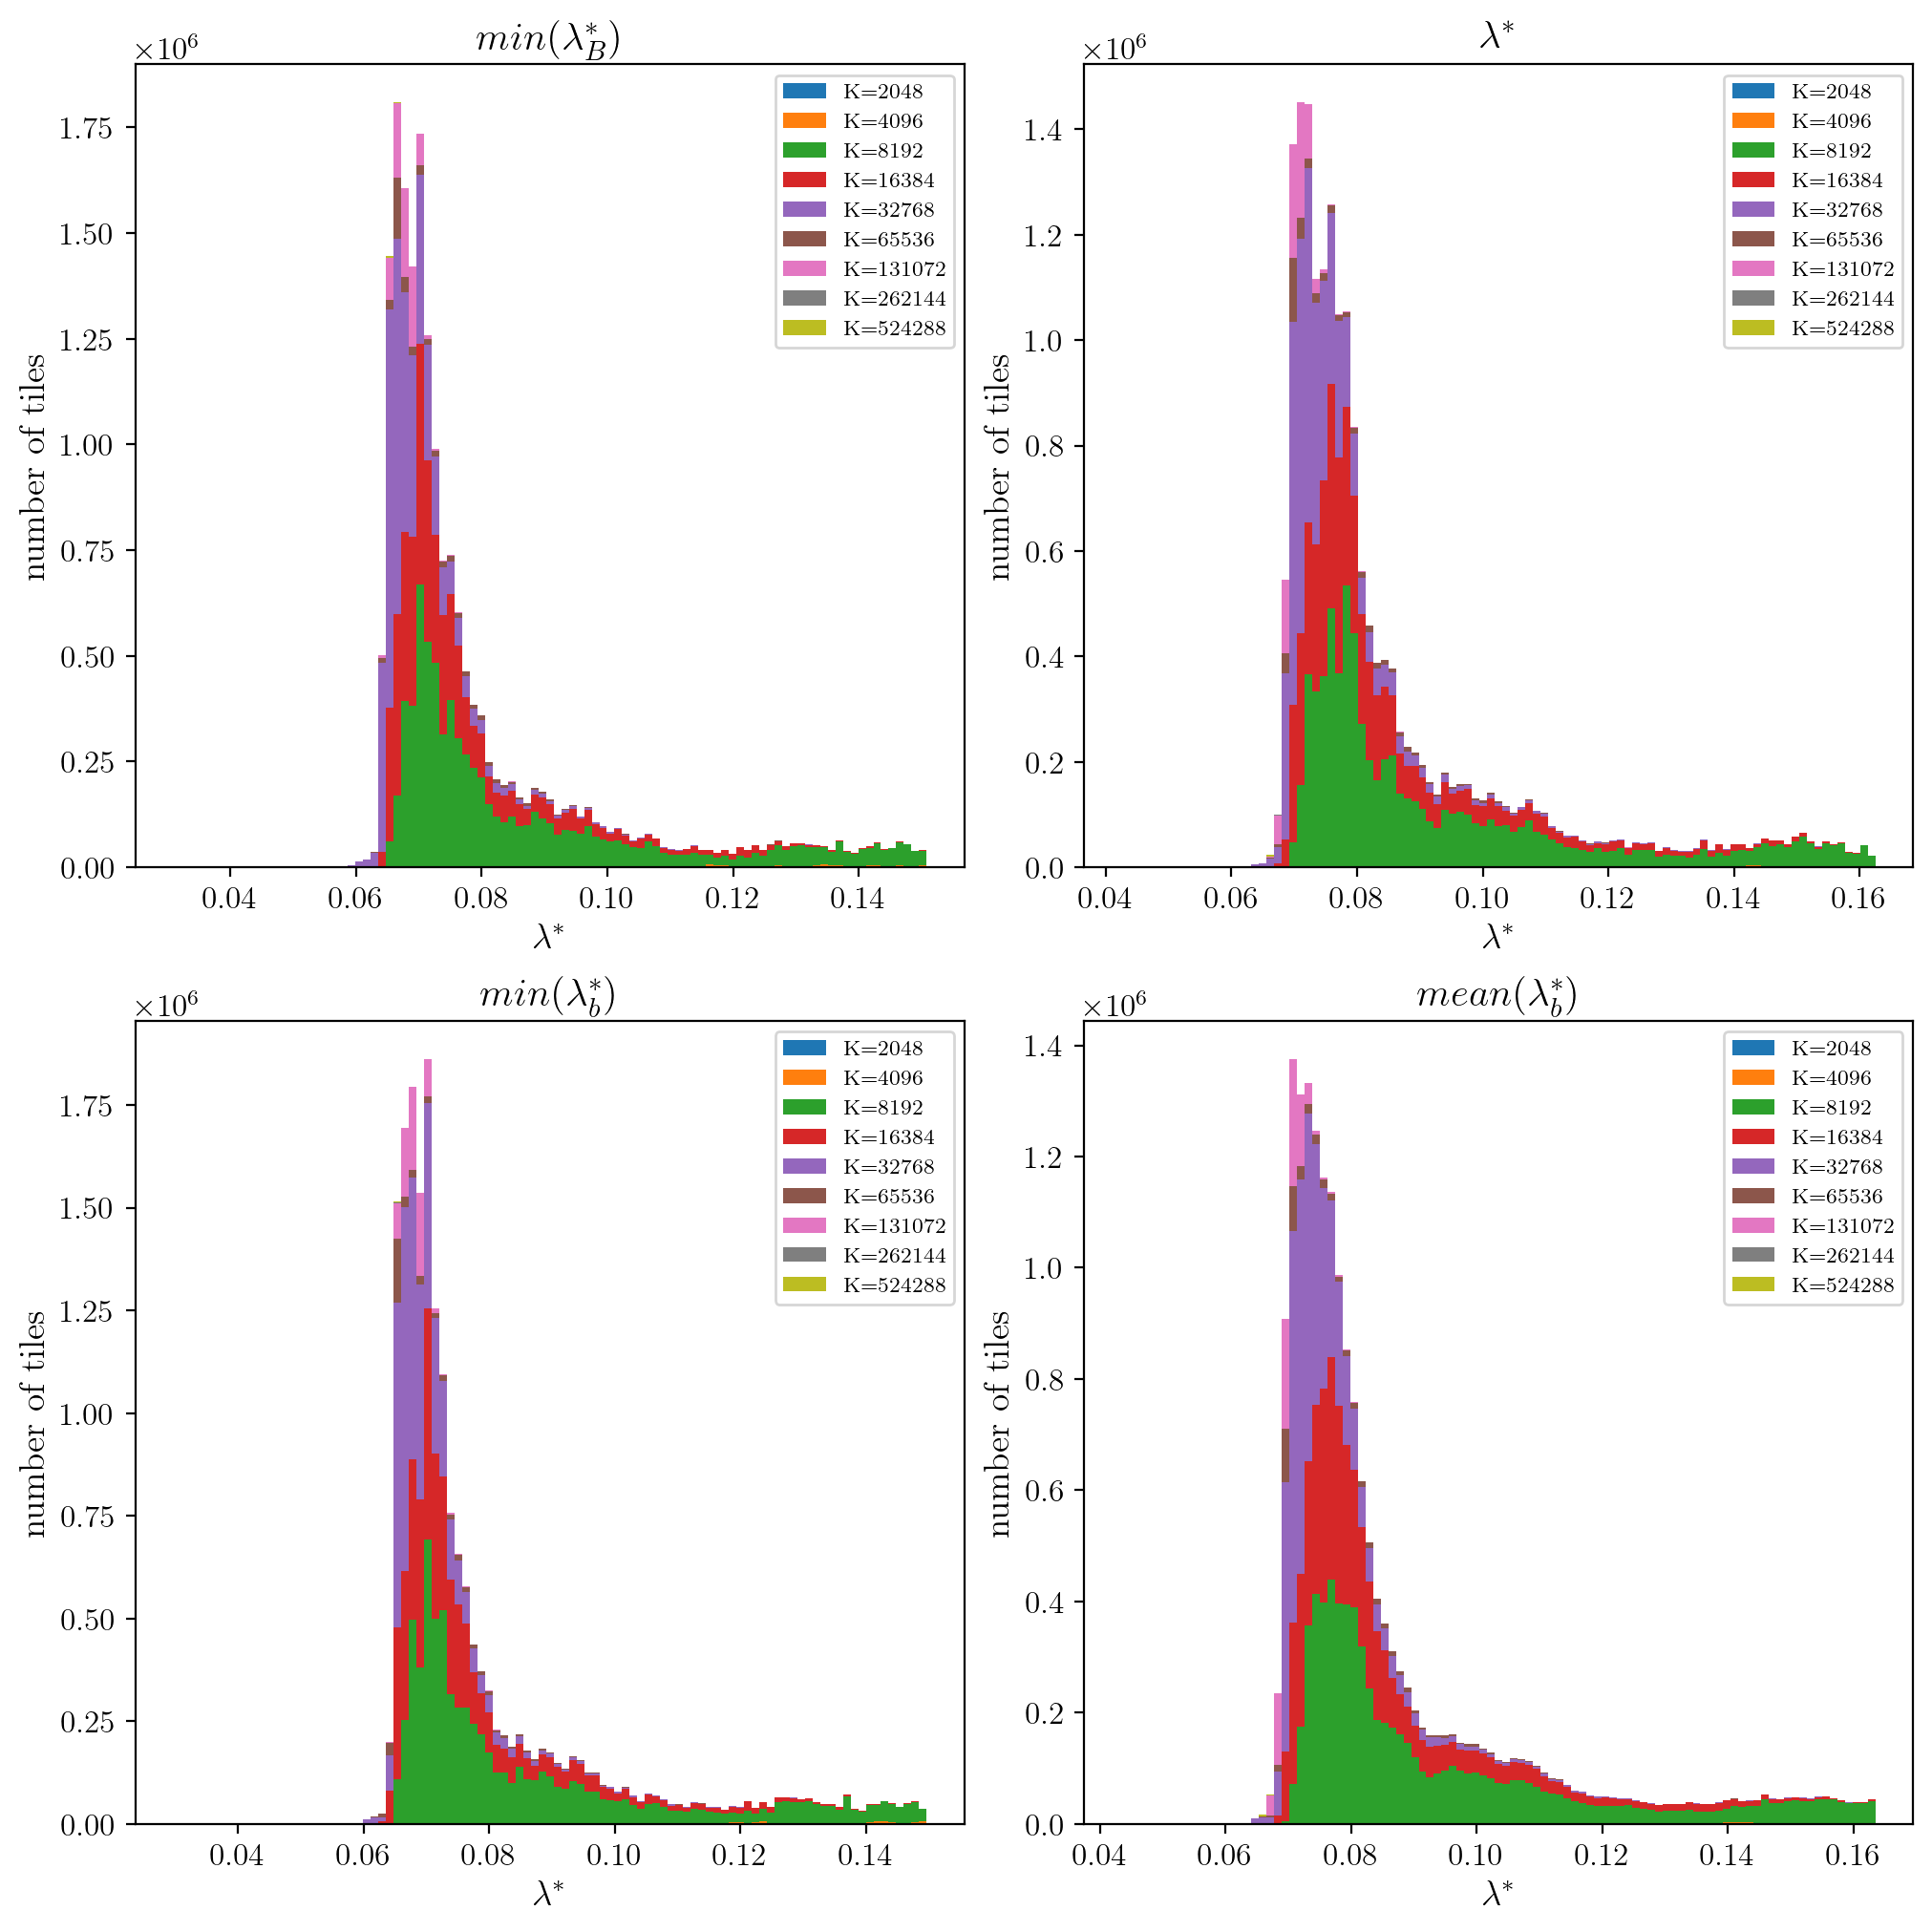

In [17]:
plt.figure(figsize=(10, 10), constrained_layout=True)
plt.subplot(2, 2, 1)
plt.title("$min(\lambda^*_B)$")
lamstar_histogram(S.B_lam.min(axis=1), S.sim_sizes)
for i, (field, title) in enumerate(
    [
        (S.orig_lam, "$\lambda^{*}$"),
        (S.twb_min_lam, "$min(\lambda^*_b)$"),
        (S.twb_mean_lam, "$mean(\lambda^*_b)$"),
    ]
):
    plt.subplot(2, 2, i + 2)
    plt.title(title)
    lamstar_histogram(field, S.sim_sizes)
plt.show()

## Scratch

## Resimulation

In [9]:
import pandas as pd

friends = np.where(bootstrap_cvs[:, 0] < 0.045)[0]
print(pd.DataFrame(sim_sizes[friends]).describe())
print(pd.DataFrame(pointwise_target_alpha[friends]).describe())

                  0
count  34476.000000
mean    1160.053370
std      564.423262
min     1000.000000
25%     1000.000000
50%     1000.000000
75%     1000.000000
max     8000.000000
                  0
count  34476.000000
mean       0.006419
std        0.002901
min        0.000561
25%        0.004503
50%        0.004715
75%        0.010948
max        0.011460


In [10]:
seed = 0
src_key = jax.random.PRNGKey(seed)
key1, key2, key3 = jax.random.split(src_key, 3)

unifs = jax.random.uniform(
    key=key1, shape=(adap.max_sim_size,) + lei_obj.unifs_shape(), dtype=jnp.float32
)
unifs_order = jnp.arange(0, unifs.shape[1])
nB_global = 30
nB_tile = 40
bootstrap_idxs = {
    K: jnp.concatenate(
        (
            jnp.arange(K)[None, :],
            jax.random.choice(key2, K, shape=(nB_global, K), replace=True),
            jax.random.choice(key3, K, shape=(nB_tile, K), replace=True),
        )
    ).astype(jnp.int32)
    for K in (adap.init_K * 2 ** np.arange(0, adap.n_sim_double + 1))
}

In [11]:
print("hi")

hi


In [12]:
which = friends[:4]
lamstar = lts.bootstrap_tune_runner(
    lei_obj,
    sim_sizes[which],
    pointwise_target_alpha[which],
    g.theta_tiles[which],
    g.null_truth[which],
    unifs,
    bootstrap_idxs,
    unifs_order,
    grid_batch_size=4,
)

tuning for 1000 simulations with 3 tiles and batch size (4, 1000)


In [13]:
stats = np.random.rand(3, 1000)

In [38]:
from confirm.lewislib import batch

grid_batch_size = 4


def printer(x, y, z):
    print(x.shape, y.shape, z.shape)
    return 0


tunev = jax.jit(
    jax.vmap(jax.vmap(lts.tune, in_axes=(None, 0, None)), in_axes=(0, None, 0))
)
batched_tune = batch.batch(
    batch.batch(tunev, 10, in_axes=(None, 0, None), out_axes=(1,)),
    grid_batch_size,
    in_axes=(0, None, 0),
)
batched_tune(stats, bootstrap_idxs[1000], np.array([0.025, 0.025, 0.025])).shape

(3, 71)

In [31]:
bootstrap_idxs[1000].shape

(71, 1000)

In [28]:
batch.batch(lts.tunev, 10, in_axes=(None, 0, None))(
    stats[0], bootstrap_idxs[1000], 0.025
).shape

(71,)

In [36]:
tunev(stats, bootstrap_idxs[1000], np.full(3, 0.025)).shape

(3, 71)

In [23]:
bootstrap_idxs[1000].shape

(71, 1000)

## Scratch

In [ ]:
# typeI_sum = batched_rej(
#     sim_sizes,
#     (np.full(sim_sizes.shape[0], overall_cv),
#     g.theta_tiles,
#     g.null_truth,),
#     unifs,
#     unifs_order,
# )

# savedata = [
#     g,
#     sim_sizes,
#     bootstrap_cvs,
#     typeI_sum,
#     hob_upper,
#     pointwise_target_alpha
# ]
# with open(f"{name}/final.pkl", "wb") as f:
#     pickle.dump(savedata, f)

# # Calculate actual type I errors?
# typeI_est, typeI_CI = binomial.zero_order_bound(
#     typeI_sum, sim_sizes, delta_validate, 1.0
# )
# typeI_bound = typeI_est + typeI_CI

# hob_upper = binomial.holder_odi_bound(
#     typeI_bound, g.theta_tiles, g.vertices, n_arm_samples, holderq
# )
# sim_cost = typeI_CI
# hob_empirical_cost = hob_upper - typeI_bound
# worst_idx = np.argmax(typeI_est)
# worst_tile = g.theta_tiles[worst_idx]
# typeI_est[worst_idx], worst_tile
# worst_cv_idx = np.argmin(sim_cvs)
# typeI_est[worst_cv_idx], sim_cvs[worst_cv_idx], g.theta_tiles[worst_cv_idx], pointwise_target_alpha[worst_cv_idx]
# plt.hist(typeI_est, bins=np.linspace(0.02,0.025, 100))
# plt.show()

# theta_0 = np.array([-1.0, -1.0, -1.0])      # sim point
# v = 0.1 * np.ones(theta_0.shape[0])     # displacement
# f0 = 0.01                               # Type I Error at theta_0
# fwd_solver = ehbound.ForwardQCPSolver(n=n_arm_samples)
# q_opt = fwd_solver.solve(theta_0=theta_0, v=v, a=f0) # optimal q
# ehbound.q_holder_bound_fwd(q_opt, n_arm_samples, theta_0, v, f0)

: 